In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [3]:
#Aumentacion de datos
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=(-0.2, 0.2)),
        #layers.RandomZoom(.1),
        layers.RandomTranslation(height_factor=(-0.2, 0.2), 
                                 width_factor=(-0.2, 0.2)),
    ]
)

# Create a tf.data pipeline of augmented images (and their labels)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(32).map(lambda x, y: (data_augmentation(x), y))


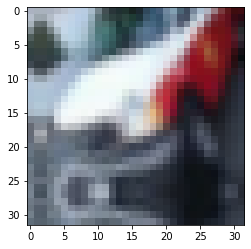

In [5]:
plt.imshow(data_augmentation(x_train[60]).numpy().astype('uint8'))

In [6]:
def plot(hist):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
    ax1.plot(hist.history['loss'], label='CCE')
    ax1.plot(hist.history['val_loss'], label='val_CCE')
    ax1.set_xlabel('Epocas', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)
    ax1.legend(loc='best')

    ax2.plot(hist.history['sparse_categorical_accuracy'], label='acc')
    ax2.plot(hist.history['val_sparse_categorical_accuracy'], label='val_acc')
    ax2.set_xlabel('Epocas', fontsize=15)
    ax2.set_ylabel('Accuracy', fontsize=15)
    ax2.legend(loc='best')

    fig.tight_layout()
    plt.show()
    return None

Red tipo AlexNet

In [23]:
keras.backend.clear_session()

reg = keras.regularizers.L2(l2=1e-3)
drop_r = 0.5

model = keras.models.Sequential(name='AlexNet')

#Capas convolucionales

model.add(keras.layers.Input(shape=(32,32,3)))
model.add(keras.layers.Rescaling(1.0 / 255))

model.add(keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))

model.add(keras.layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2))

model.add(keras.layers.Conv2D(352, 3, strides=1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(352, 3, strides=1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(256, 3, strides=1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=drop_r))


#Capas densas

model.add(keras.layers.Dense(2048, activation='relu', kernel_regularizer=reg))
model.add(keras.layers.Dropout(rate=drop_r))
model.add(keras.layers.Dense(2048, activation='relu', kernel_regularizer=reg))
model.add(keras.layers.Dropout(rate=drop_r))
model.add(keras.layers.Dense(10, activation='sigmoid', kernel_regularizer=reg))

model.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 128)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        512 

In [24]:
def scheduler(epoch, lr):
  if epoch==10 or epoch == 25 or epoch == 50 or epoch == 75:
    return lr/3
  else:
    return lr


callbacks_list=[
    keras.callbacks.LearningRateScheduler(
    scheduler, verbose=0
    )
]

In [25]:
opt = keras.optimizers.Adam(learning_rate=.0003)


model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

hist = model.fit(train_dataset, validation_data=(x_test, y_test), 
                 callbacks=callbacks_list, epochs=100, verbose=1)

Epoch 1/100
1563/1563 [==============================] - 33s 19ms/step - loss: 4.8741 - sparse_categorical_accuracy: 0.2759 - val_loss: 3.8800 - val_sparse_categorical_accuracy: 0.3551 - lr: 3.0000e-04
Epoch 2/100
1563/1563 [==============================] - 27s 17ms/step - loss: 3.1651 - sparse_categorical_accuracy: 0.3949 - val_loss: 2.4543 - val_sparse_categorical_accuracy: 0.4547 - lr: 3.0000e-04
Epoch 3/100
1563/1563 [==============================] - 28s 18ms/step - loss: 2.2105 - sparse_categorical_accuracy: 0.4511 - val_loss: 1.8636 - val_sparse_categorical_accuracy: 0.4963 - lr: 3.0000e-04
Epoch 4/100
1563/1563 [==============================] - 29s 19ms/step - loss: 1.7990 - sparse_categorical_accuracy: 0.4834 - val_loss: 1.6422 - val_sparse_categorical_accuracy: 0.5186 - lr: 3.0000e-04
Epoch 5/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.6086 - sparse_categorical_accuracy: 0.5129 - val_loss: 1.5995 - val_sparse_categorical_accuracy: 0.5120 - lr: 3

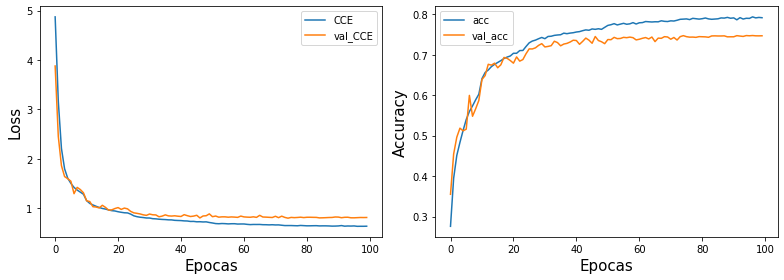

In [26]:
plot(hist)